<a href="https://colab.research.google.com/github/chirag2saraiya/phase2_nlp_1/blob/master/Phase2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/'My Drive'/aclImdb.zip /content

In [0]:
!unzip /content/aclImdb.zip

In [0]:
#Processing the labels of the raw IMDB data
import os
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

In [5]:
print(len(labels))
print(len(texts))

25000
25000


In [6]:
#Tokenizing the text of the raw IMDB data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
#Cuts off reviews after 100 words
maxlen = 100
#Trains on 8000 samples
training_samples = 8000
#Validates on 10,000 samples
validation_samples = 10000
#Considers only the top 10,000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

"""Splits the data into a training set and a validation set, 
but first shuffles the data, because you’re starting with data in which samples are ordered 
(all negative first, then all positive)"""
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [0]:
!cp /content/drive/'My Drive'/glove.6B.zip /content/

In [8]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
!mkdir glove.6B

In [0]:
!mv glove.6B.* /content/glove.6B

In [11]:
#Parsing the GloVe word-embeddings file
glove_dir = '/content/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
#Preparing the GloVe word-embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [13]:
#Model definition
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Loading pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [15]:
#Training and evaluation

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=50,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 10000 samples
Epoch 1/50
8000/8000 [==============================] - 3s 395us/step - loss: 0.7231 - acc: 0.5664 - val_loss: 0.6534 - val_acc: 0.6435
Epoch 2/50
8000/8000 [==============================] - 1s 159us/step - loss: 0.5920 - acc: 0.6941 - val_loss: 0.6683 - val_acc: 0.6099
Epoch 3/50
8000/8000 [==============================] - 1s 156us/step - loss: 0.4995 - acc: 0.7614 - val_loss: 0.6036 - val_acc: 0.6796
Epoch 4/50
8000/8000 [==============================] - 1s 160us/step - loss: 0.4181 - acc: 0.8161 - val_loss: 0.9890 - val_acc: 0.5969
Epoch 5/50
8000/8000 [==============================] - 1s 156us/step - loss: 0.3666 - acc: 0.8390 - val_loss: 0.7186 - val_acc: 0.6740
Epoch 6/50
8000/8000 [==============================] - 1s 165us/step - loss: 0.3049 - acc: 0.8707 - val_loss: 0.6520 - val_acc: 0.6990
Epoch 7/50
8000/8000 [===============

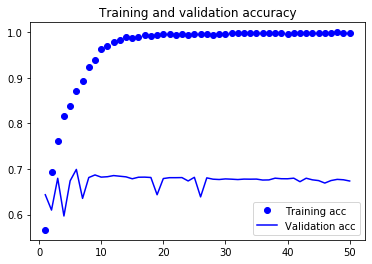

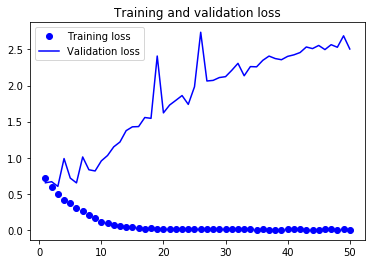

In [16]:
#Plotting the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()